In [16]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np 
import pandas as pd 

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

# Load the dataset
file_path = '../data/diabetes_prediction_dataset.csv'
df = pd.read_csv(file_path)

In [17]:
# Define a function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())



smoking_history
non-smoker     70911
past_smoker    19803
current         9286
Name: count, dtype: int64


In [18]:
data = df.copy()

In [19]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

data.to_csv('preprocessed_data.csv', index=False)


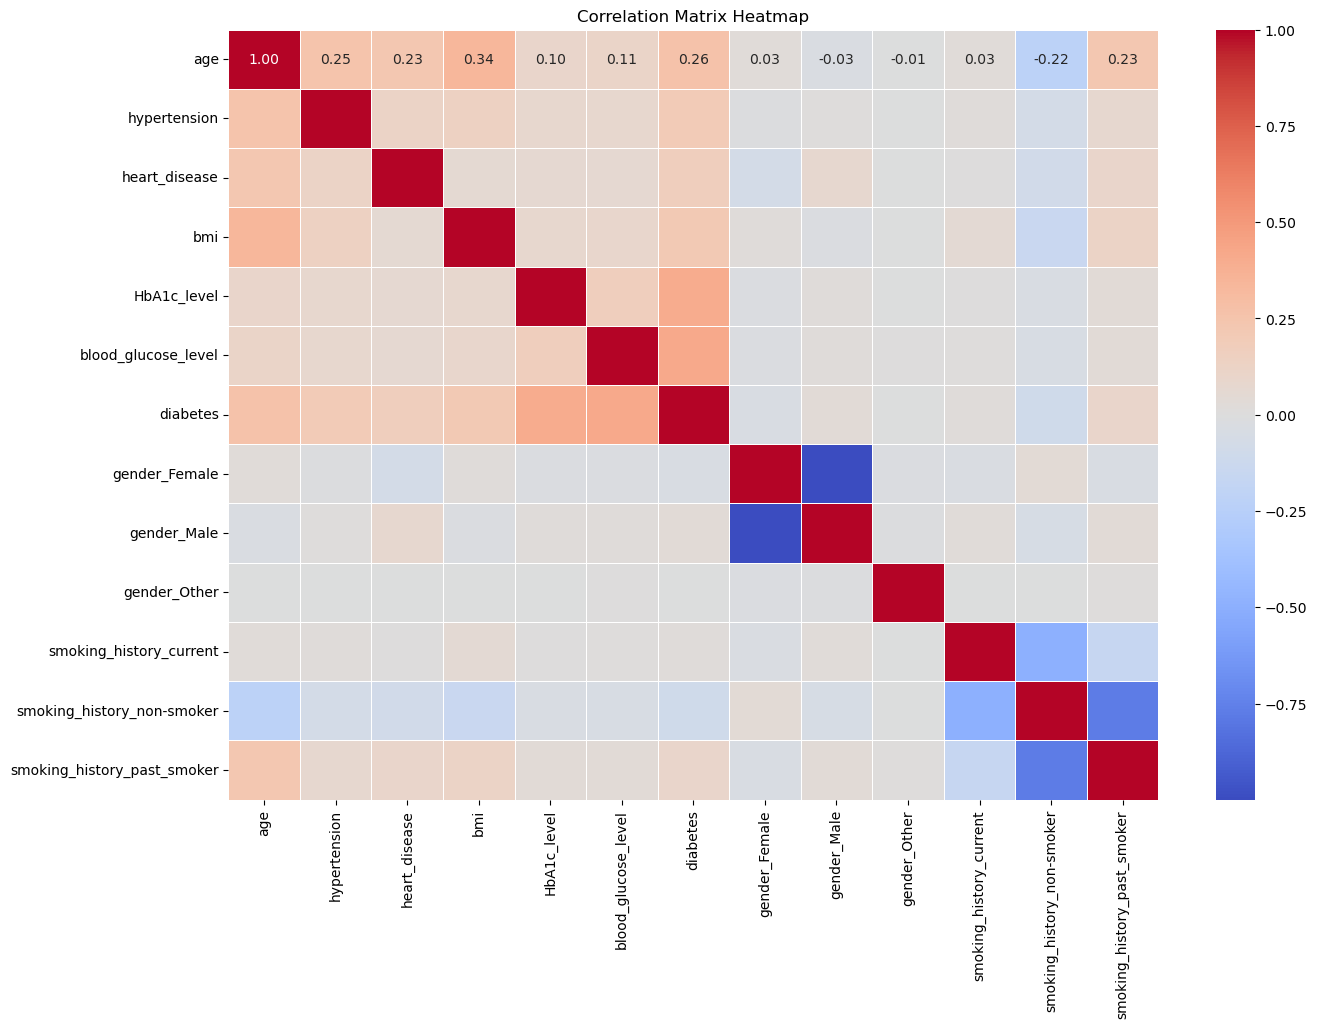

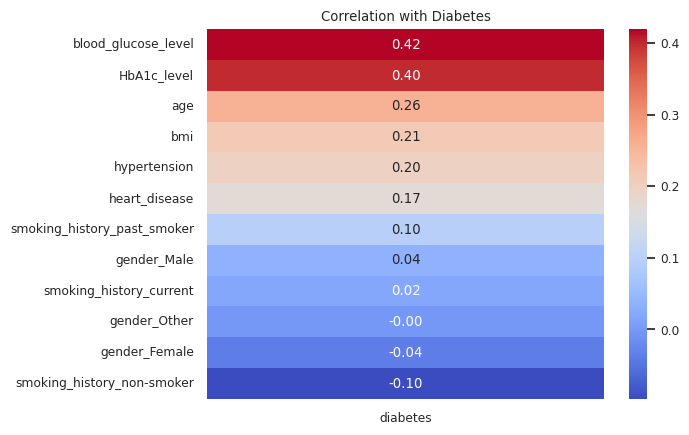

In [20]:
# Compute the correlation matrix
from matplotlib import pyplot as plt
import seaborn as sns

correlation_matrix = data.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

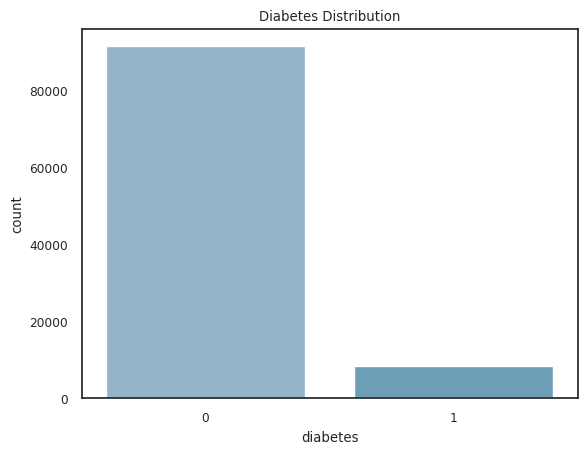

In [21]:
# Count plot for the 'diabetes' variable
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Define resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [33]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']
df.to_csv('preprocessed_data.csv', index=False)


In [ ]:
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

In [ ]:
# Define the hyperparameters and the values we want to test
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}


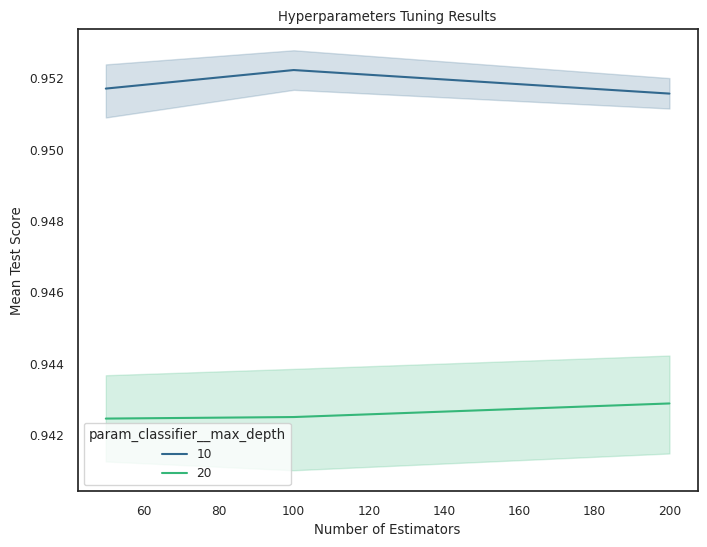

In [ ]:
# Convert GridSearchCV results to a DataFrame and plot
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__max_depth', palette='viridis')
plt.title('Hyperparameters Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()

Model Accuracy:  0.95445
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18292
           1       0.70      0.82      0.75      1708

    accuracy                           0.95     20000
   macro avg       0.84      0.89      0.86     20000
weighted avg       0.96      0.95      0.96     20000



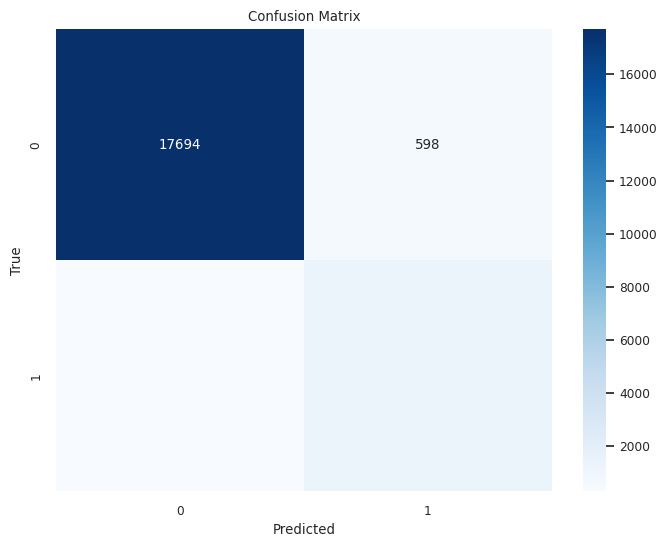

In [ ]:
# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate the model
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [32]:
from joblib import dump

preprocessor.fit(X)
joblib.dump(preprocessor.named_transformers_['num'], 'scaler.joblib')
joblib.dump(preprocessor.named_transformers_['cat'], 'encoder.joblib')

['encoder.joblib']

In [29]:
# Export the best estimator from your grid search
best_model = grid_search.best_estimator_

# Save your model to a file
dump(best_model, 'diabetes_prediction_model.joblib')


AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'